In [1]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

(512, 512)


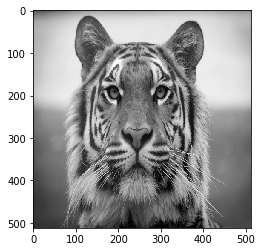

In [2]:
im = cv2.imread('08.png',0)
print(im.shape)
plt.imshow(im,cmap='gray')

# Décomposition en Ondelette

In [16]:
def histogram(array, mode='classique'):
    """Plot histogram avec normalisation par le nombre de pixel et définition de l'axe des abscisses"""
    if mode=='joli':    
        hist, bin_edges = np.histogram(array,bins=100,range=[-150,150])
    if mode == 'classique':
        hist, bin_edges = np.histogram(array,bins=100)

    plt.plot(bin_edges[1:],hist/array.size)
    plt.title(f"size of image : ({array.shape[1]},{array.shape[2]})")

In [17]:
nb_level = 3

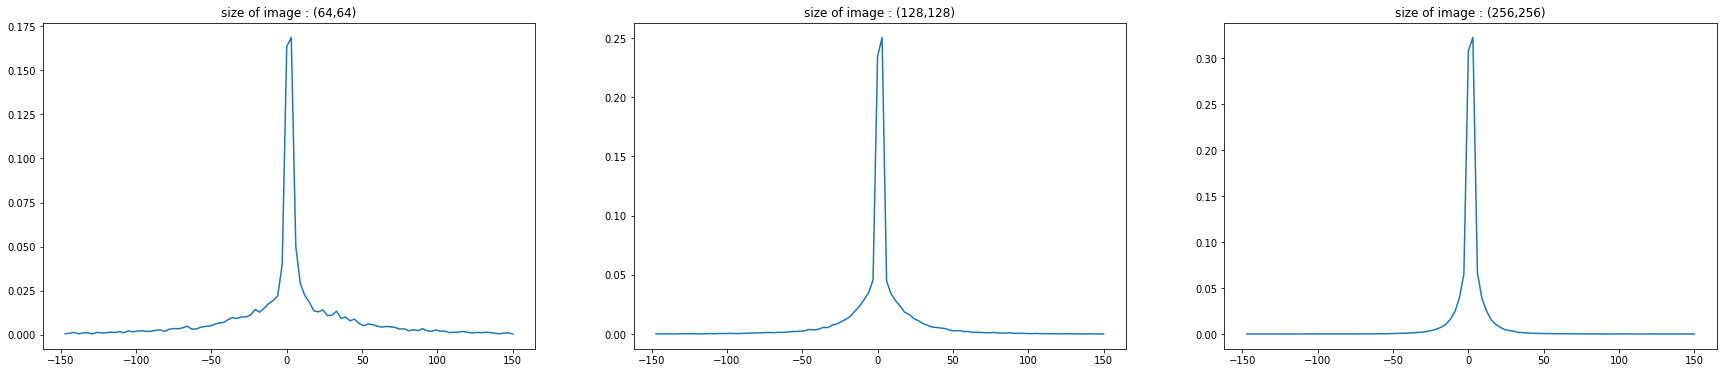

In [18]:
# compute the 2D DWT
c = pywt.wavedec2(im, 'db2',mode='periodization', level=nb_level)
arr, slices = pywt.coeffs_to_array(c)
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([c[level][0],c[level][1],c[level][2]]),'joli')

## Quantification

In [19]:
def filtrage(array,bits_goal):
    val_max = 2**bits_goal-1
    return np.where((array < -val_max) | (array > val_max),0,array)

In [40]:
delta = [2**1,2**2,2**3]
bits_goal = [7,6,5]
q = [c[0]]
for level in range(1,nb_level+1):
    temp = []
    for detail in range(3):
        # temp.append(c[level][detail])
        temp.append(filtrage(c[level][detail],bits_goal[level-1]))
        # temp.append(np.fix(c[level][detail])/delta[level-1])
    q.append(temp)

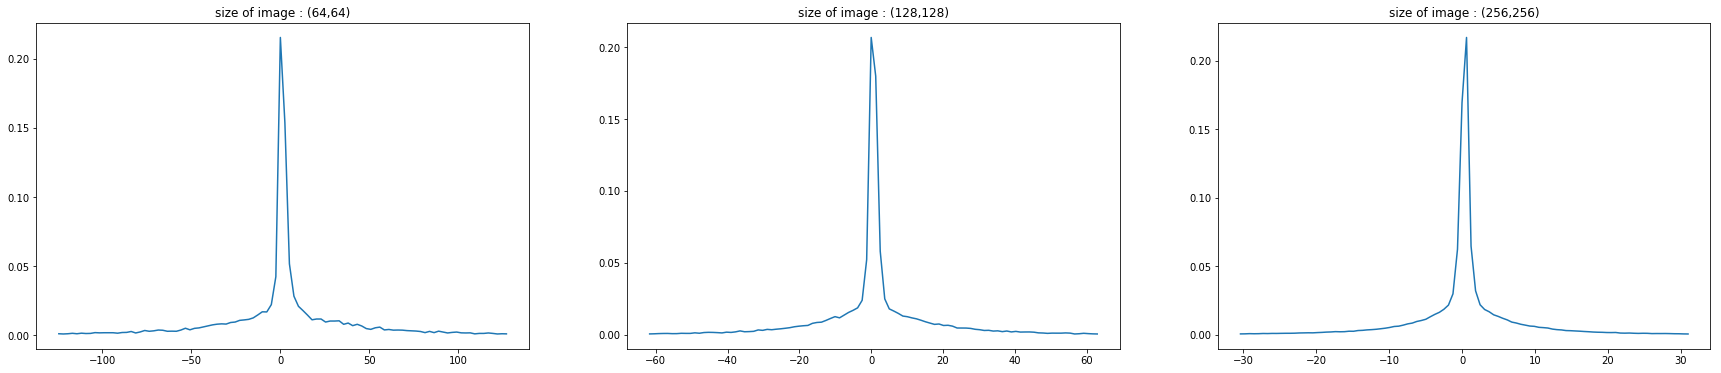

In [41]:
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([q[level][0],q[level][1],q[level][2]]))

In [42]:
def nb_bits(n):
    n_bits = 0
    while n>2**n_bits:
        n_bits+=1
    return n_bits

In [43]:
print(nb_bits(np.max(np.abs(q[0]))))
for level in range(1,nb_level+1):
    temp = np.array([q[level][0],q[level][1],q[level][2]])
    print(nb_bits(np.max(np.abs(temp))))

11
7
6
5


## Reconstruction

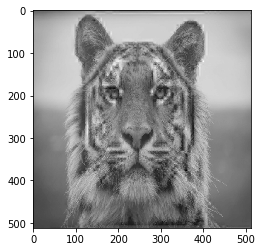

In [44]:
im_rec = pywt.waverec2(q,'db2', mode='periodization')
plt.imshow(im_rec,cmap='gray')

## Mesure de l'erreur & Taux de compression

(-0.5, 511.5, 511.5, -0.5)

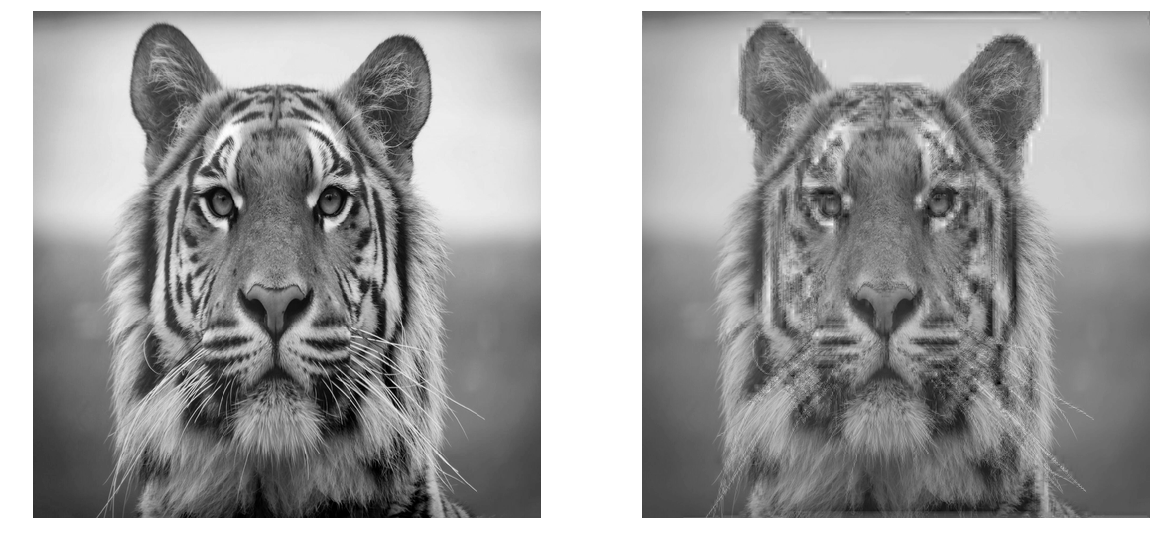

In [45]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(im_rec,cmap='gray')
plt.axis('off')

In [46]:
def comp_rmse(im_comp,im_ori):
    return np.sqrt(np.linalg.norm(im_comp-im_ori)**2/im_ori.shape[0]*im_ori.shape[1])

In [47]:
def taux_comp(q):
    p_comp = q[0].size*8 # Approx
    for level in range(1,nb_level+1):
        temp = np.array([q[level][0],q[level][1],q[level][2]])
        nb_bit_max = nb_bits(np.max(np.abs(temp)))+1
        p_comp += nb_bit_max * temp.size
        #print(p_comp)
    return (8*im.size)/p_comp

In [48]:
print(f"Error : {comp_rmse(im_rec,im)}")
print(f"Taux de compression : {taux_comp(q)}")

Error : 7754.238197779629
Taux de compression : 1.2673267326732673
